# labelImg로 처리한 커스텀 데이터 학습

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1. 준비

In [ ]:
# git clone
#!git clone https://github.com/AlexeyAB/darknet7

Cloning into 'darknet'...
remote: Enumerating objects: 15825, done.
remote: Counting objects: 100% (286/286), done.
remote: Compressing objects: 100% (163/163), done.
remote: Total 15825 (delta 148), reused 202 (delta 121), pack-reused 15539
Receiving objects: 100% (15825/15825), 14.76 MiB | 20.10 MiB/s, done.
Resolving deltas: 100% (10578/10578), done.


In [ ]:
# 구글 드라이브 마운트
# 업로드 파일
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 이미지들의 경로를 리스트 형태로 생성
from glob import glob

img_list = glob('/content/drive/MyDrive/sunghyun/darknet/data/obj/*.png')
img_list += glob('/content/drive/MyDrive/sunghyun/darknet/data/obj/*.jpg')

len(img_list)

948

In [ ]:
948*2

1896

In [ ]:
# 학습과 검증셋 분할
# -> 아직 데이터가 별로 없어서 x
from sklearn.model_selection import train_test_split

train_img_list, test_img_list = train_test_split(img_list, test_size=0.1, random_state=42) # random_state는 임의로 선택

print(len(train_img_list), len(test_img_list))

853 95


In [ ]:
# 학습 이미지 리스트와 검증 이미지 리스트를 각각 train.txt와 text.txt 파일에 저장
with open('/content/drive/MyDrive/sunghyun/darknet/data/train.txt', 'w') as f:
    #f.write('\n'.join(train_img_list) + '\n')
    f.write('\n'.join(img_list) + '\n')

with open('/content/drive/MyDrive/sunghyun/darknet/data/test.txt', 'w') as f:
    #f.write('\n'.join(test_img_list) + '\n')
    f.write('\n'.join(img_list) + '\n')

In [ ]:
# make 파일 생성
# OpenCV, GPU 사용을 위
# 바이너리 파일을 생성하는 컴파일 명령어
# 프로젝트에 필요한 파일과 의존성을 자동 컴파일하고 링크
%cd /content/drive/MyDrive/sunghyun/darknet
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile
!sed -i 's/CUDNN_HALF=0/CUDNN_HALF=1/' Makefile
!sed -i 's/LIBSO=0/LIBSO=1/' Makefile
!make

/content/drive/MyDrive/sunghyun/darknet
mkdir -p backup
mkdir -p results
chmod +x *.sh
g++ -std=c++11 -std=c++11 -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv4 2> /dev/null || pkg-config --cflags opencv` -DGPU -I/usr/local/cuda/include/ -DCUDNN -DCUDNN_HALF -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -rdynamic -Ofast -DOPENCV -DGPU -DCUDNN -I/usr/local/cudnn/include -DCUDNN_HALF -fPIC -c ./src/image_opencv.cpp -o obj/image_opencv.o
./src/image_opencv.cpp: In function ‘void draw_detections_cv_v3(void**, detection*, int, float, char**, image**, int, int)’:
./src/image_opencv.cpp:945:23: warning: variable ‘rgb’ set but not used []8;;https://gcc.gnu.org/onlinedocs/gcc/Warning-Options.html#index-Wunused-but-set-variable-Wunused-but-set-variable]8;;]
  945 |                 float rgb[3];
      |                       ^~~
./src/image_opencv.cpp: In function ‘void cv_draw_object(image, float*, int, int, int*, float*, int*, int, char**)’:
./sr

## 2. 학습하기

In [ ]:
!./content/drive/MyDrive/sunghyun/darknet detector train /content/darknet/data/obj.data /content/darknet/cfg/yolov4-tiny-obj.cfg /content/darknet/yolov4.conv.137 -dont_show


/bin/bash: line 1: ./content/drive/MyDrive/sunghyun/darknet: No such file or directory


In [ ]:
import subprocess
import time

# Darknet 실행 명령어
command = "./darknet detector train ./data/obj.data ./cfg/yolov4-tiny-obj.cfg ./yolov4.conv.137 -dont_show -map l tee train.log"

# Subprocess로 Darknet 실행
process = subprocess.Popen(command, shell=True, stdout=subprocess.PIPE, stderr=subprocess.STDOUT, bufsize=1, universal_newlines=True)

# 학습 중단 기준 손실 값
target_loss = 0.1

# 학습 시작 시간 기록
start_time = time.time()

for line in process.stdout:
    print(line.strip())

    # 손실 값을 추출
    if "avg loss:" in line:
        loss = float(line.split("avg loss: ")[-1].split(",")[0])

        # 조건 2: 일정 시간 동안 개선이 없을 때 학습 중단
        elapsed_time = time.time() - start_time
        if elapsed_time > 600:  # 10분이 지나면 중단
            print(f"Training for 1 hour. Stopping training.")
            process.terminate()
            break

        # 조건 3: 손실 값이 목표치 이하로 떨어졌을 때 학습 중단
        if loss < target_loss:
            print(f"Reached target loss of {target_loss}. Stopping training.")
            process.terminate()
            break


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.873539), count: 4, class_loss = 0.001744, iou_loss = 0.434521, total_loss = 0.436265
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.001156, iou_loss = 0.000000, total_loss = 0.001156
total_bbox = 2638155, rewritten_bbox = 0.000000 %
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.899177), count: 3, class_loss = 0.167885, iou_loss = 0.252787, total_loss = 0.420672
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.863653), count: 1, class_loss = 0.191528, iou_loss = 0.649819, total_loss = 0.841347
total_bbox = 2638159, rewritten_bbox = 0.000000 %
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.830286), count: 4, class_loss = 0.105489, iou_loss = 1.251243, total_loss = 1.356732
v3 (iou loss, Normalizer: (io

In [ ]:
%cd /content/drive/MyDrive/sunghyun/darknet

/content/drive/MyDrive/sunghyun/darknet


In [ ]:
def imShow(path):
  import cv2
  import matplotlib.pyplot as plt
  %matplotlib inline

  image = cv2.imread(path)
  height, width = image.shape[:2]
  resized_image = cv2.resize(image, (3*width, 3*height), interpolation = cv2.INTER_CUBIC)

  fig = plt.gcf()
  fig.set_size_inches(18, 10)
  plt.axis("off")
  plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
  plt.show()

def upload():
  from google.colab import files
  uploaded = files.upload()
  for name, data in uploaded.items():
    with open(name, 'wb') as f:
      f.write(data)
      print('saved file', name)
def download(path):
  from google.colab import files
  files.download(path)

In [ ]:
!./darknet detector test ./data/obj.data ./cfg/yolov4-tiny-obj.cfg ./backup/yolov4-tiny-obj_best.weights -dont_show -ext_output <./data/test.txt> result.txt
download('result.txt')

 CUDA-version: 11080 (12000), cuDNN: 8.9.0, CUDNN_HALF=1, GPU count: 1  
 OpenCV version: 4.5.4
 0 : compute_capability = 700, cudnn_half = 1, GPU: Tesla V100-SXM2-16GB 
   layer   filters  size/strd(dil)      input                output
   0 conv     32       3 x 3/ 2    416 x 416 x   3 ->  208 x 208 x  32 0.075 BF
   1 conv     64       3 x 3/ 2    208 x 208 x  32 ->  104 x 104 x  64 0.399 BF
   2 conv     64       3 x 3/ 1    104 x 104 x  64 ->  104 x 104 x  64 0.797 BF
   3 route  2 		                       1/2 ->  104 x 104 x  32 
   4 conv     32       3 x 3/ 1    104 x 104 x  32 ->  104 x 104 x  32 0.199 BF
   5 conv     32       3 x 3/ 1    104 x 104 x  32 ->  104 x 104 x  32 0.199 BF
   6 route  5 4 	                           ->  104 x 104 x  64 
   7 conv     64       1 x 1/ 1    104 x 104 x  64 ->  104 x 104 x  64 0.089 BF
   8 route  2 7 	                           ->  104 x 104 x 128 
   9 max                2x 2/ 2    104 x 104 x 128 ->   52 x  52 x 128 0.001 BF
  10 con

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

모델 저장하기:
모델을 저장하는 기능은 Darknet에서 제공하는 기능 중 하나가 아닙니다. 따라서 모델을 저장하기 위해서는 직접 코드를 수정하고 컴파일해야 합니다.

일반적으로 Darknet은 학습이 끝난 후 학습된 가중치를 .weights 파일로 저장합니다. 이 파일은 모델의 구조와 학습된 가중치를 모두 포함하고 있습니다.

모델 불러오기:
모델을 사용할 때는 먼저 구조와 가중치가 정확하게 맞아야 합니다. 따라서 사용하려는 모델과 동일한 구조로 Darknet을 빌드하고 컴파일해야 합니다.

그런 다음, 저장된 .weights 파일을 사용하여 모델을 로드할 수 있습니다. 이를 위해 darknet 실행 파일을 사용합니다.

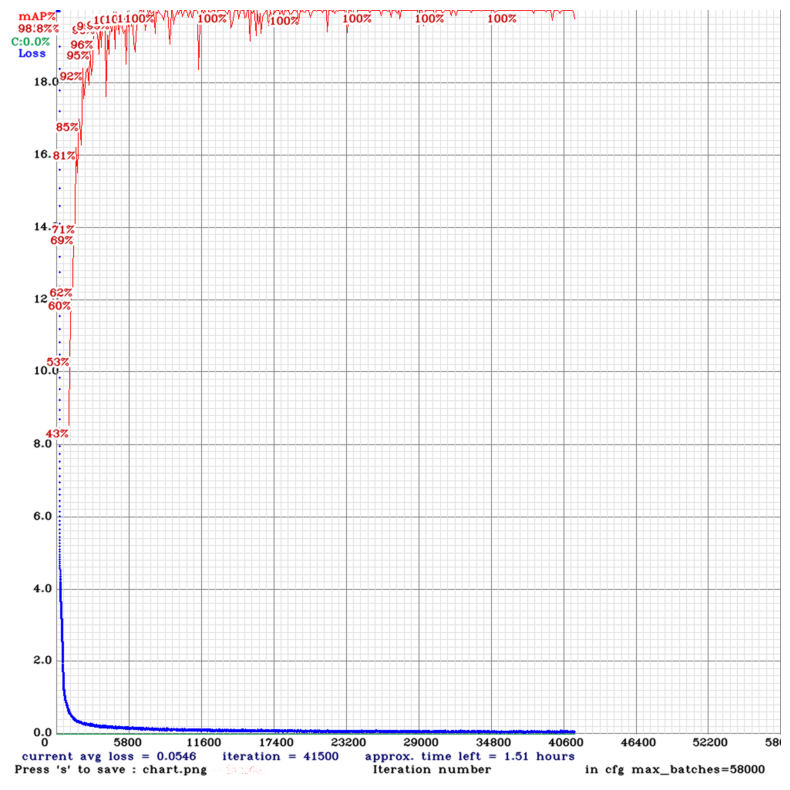

In [ ]:
imShow('chart.png')

### test

In [ ]:
# import dependencies
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from google.colab.patches import cv2_imshow
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# make 파일 생성
# OpenCV, GPU 사용을 위
# 바이너리 파일을 생성하는 컴파일 명령어
# 프로젝트에 필요한 파일과 의존성을 자동 컴파일하고 링크
# change makefile to have GPU, OPENCV and LIBSO enabled
%cd /content/drive/MyDrive/sunghyun/darknet
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile
!sed -i 's/CUDNN_HALF=0/CUDNN_HALF=1/' Makefile
!sed -i 's/LIBSO=0/LIBSO=1/' Makefile

/content/drive/MyDrive/sunghyun/darknet


In [ ]:
# make darknet (builds darknet so that you can then use the darknet.py file and have its dependencies)
!make

chmod +x *.sh
g++ -std=c++11 -std=c++11 -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv4 2> /dev/null || pkg-config --cflags opencv` -DGPU -I/usr/local/cuda/include/ -DCUDNN -DCUDNN_HALF -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -rdynamic -Ofast -DOPENCV -DGPU -DCUDNN -I/usr/local/cudnn/include -DCUDNN_HALF -fPIC -c ./src/image_opencv.cpp -o obj/image_opencv.o
./src/image_opencv.cpp: In function ‘void draw_detections_cv_v3(void**, detection*, int, float, char**, image**, int, int)’:
./src/image_opencv.cpp:945:23: warning: variable ‘rgb’ set but not used []8;;https://gcc.gnu.org/onlinedocs/gcc/Warning-Options.html#index-Wunused-but-set-variable-Wunused-but-set-variable]8;;]
  945 |                 float rgb[3];
      |                       ^~~
./src/image_opencv.cpp: In function ‘void cv_draw_object(image, float*, int, int, int*, float*, int*, int, char**)’:
./src/image_opencv.cpp:1443:14: warning: unused variable ‘buff’ []8;;https:/

In [ ]:
# import darknet functions to perform object detections
from darknet import *
# load in our YOLOv4 architecture network
network, class_names, class_colors = load_network("cfg/yolov4-tiny-obj.cfg", "data/obj.data", "backup/yolov4-tiny-obj_best.weights")
width = network_width(network)
height = network_height(network)

# darknet helper function to run detection on image
def darknet_helper(img, width, height):
  darknet_image = make_image(width, height, 3)
  img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img_resized = cv2.resize(img_rgb, (width, height),
                              interpolation=cv2.INTER_LINEAR)

  # get image ratios to convert bounding boxes to proper size
  img_height, img_width, _ = img.shape
  width_ratio = img_width/width
  height_ratio = img_height/height

  # run model on darknet style image to get detections
  copy_image_from_bytes(darknet_image, img_resized.tobytes())
  detections = detect_image(network, class_names, darknet_image)
  free_image(darknet_image)
  return detections, width_ratio, height_ratio

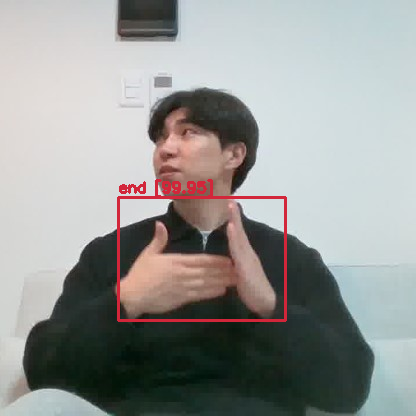

In [ ]:
# run test on person.jpg image that comes with repository
image = cv2.imread("data/obj/end_188.jpg")
detections, width_ratio, height_ratio = darknet_helper(image, width, height)

for label, confidence, bbox in detections:
  left, top, right, bottom = bbox2points(bbox)
  left, top, right, bottom = int(left * width_ratio), int(top * height_ratio), int(right * width_ratio), int(bottom * height_ratio)
  cv2.rectangle(image, (left, top), (right, bottom), class_colors[label], 2)
  cv2.putText(image, "{} [{:.2f}]".format(label, float(confidence)),
                    (left, top - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                    class_colors[label], 2)
cv2_imshow(image)

In [ ]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

In [ ]:
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)

  # get photo data
  data = eval_js('takePhoto({})'.format(quality))
  # get OpenCV format image
  img = js_to_image(data)

  # call our darknet helper on webcam image
  detections, width_ratio, height_ratio = darknet_helper(img, width, height)

  # loop through detections and draw them on webcam image
  for label, confidence, bbox in detections:
    left, top, right, bottom = bbox2points(bbox)
    left, top, right, bottom = int(left * width_ratio), int(top * height_ratio), int(right * width_ratio), int(bottom * height_ratio)
    cv2.rectangle(img, (left, top), (right, bottom), class_colors[label], 2)
    cv2.putText(img, "{} [{:.2f}]".format(label, float(confidence)),
                      (left, top - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                      class_colors[label], 2)
  # save image
  cv2.imwrite(filename, img)

  return filename

<IPython.core.display.Javascript object>

Saved to photo.jpg


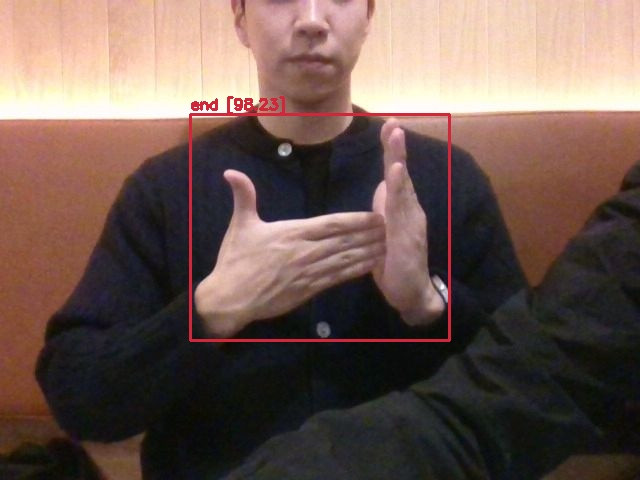

In [ ]:
try:
  filename = take_photo('photo.jpg')
  print('Saved to {}'.format(filename))

  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

# YOLOv4 on Webcam Videos
Running YOLOv4 on webcam video is a little more complex than images. We need to start a video stream using our webcam as input. Then we run each frame through our YOLOv4 model and create an overlay image that contains bounding box of detection(s). We then overlay the bounding box image back onto the next frame of our video stream.

YOLOv4 is so fast that it can run the detections in real-time!

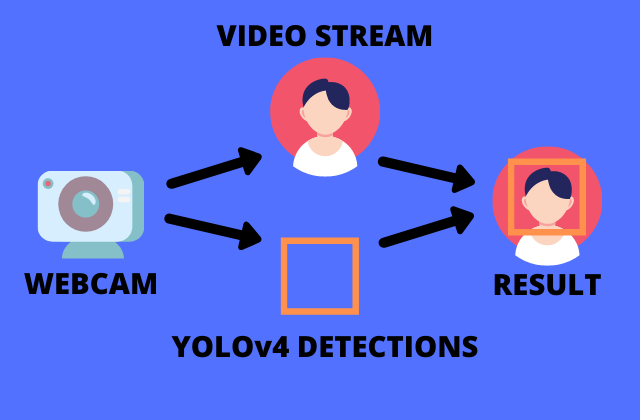

Below is a function to start up the video stream using similar JavaScript as was used for images. The video stream frames are fed as input to YOLOv4.

In [ ]:
# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;

    var pendingResolve = null;
    var shutdown = false;

    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }

    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }

    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);

      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);

      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);

      const instruction = document.createElement('div');
      instruction.innerHTML =
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };

      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);

      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();

      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }

      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }

      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;

      return {'create': preShow - preCreate,
              'show': preCapture - preShow,
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)

def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

## Running on Webcam Video

In [ ]:
# start streaming video from webcam
video_stream()
# label for video
label_html = 'Capturing...'
# initialze bounding box to empty
bbox = ''
count = 0
while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # convert JS response to OpenCV Image
    frame = js_to_image(js_reply["img"])

    # create transparent overlay for bounding box
    bbox_array = np.zeros([480,640,4], dtype=np.uint8)

    # call our darknet helper on video frame
    detections, width_ratio, height_ratio = darknet_helper(frame, width, height)

    # loop through detections and draw them on transparent overlay image
    for label, confidence, bbox in detections:
      left, top, right, bottom = bbox2points(bbox)
      left, top, right, bottom = int(left * width_ratio), int(top * height_ratio), int(right * width_ratio), int(bottom * height_ratio)
      bbox_array = cv2.rectangle(bbox_array, (left, top), (right, bottom), class_colors[label], 2)
      bbox_array = cv2.putText(bbox_array, "{} [{:.2f}]".format(label, float(confidence)),
                        (left, top - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                        class_colors[label], 2)

    bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
    # convert overlay of bbox into bytes
    bbox_bytes = bbox_to_bytes(bbox_array)
    # update bbox so next frame gets new overlay
    bbox = bbox_bytes

<IPython.core.display.Javascript object>

## 테스트 결과 출력

In [ ]:
%cd /content/drive/MyDrive/sunghyun/darknet

/content/drive/MyDrive/sunghyun/darknet


In [ ]:
# result.txt에서 불필요한 부분 제거
with open('result.txt', 'r') as file:
    lines = file.readlines()

modified_lines = []

for line in lines:
    if "Detection layer: 30 - type = 28" not in line and "Detection layer: 37 - type = 28" not in line:
        if line.startswith('/'):
            modified_line = "Enter Image Path: " + line
            modified_lines.append(modified_line)
        else:
            modified_lines.append(line)

with open('output_file.txt', 'w') as file:
    file.write(''.join(modified_lines))

In [ ]:
%cp result.txt /content/drive/MyDrive/sunghyun/darknet/mAP/scripts/extra
%cd /content/drive/MyDrive/sunghyun/darknet/mAP/scripts/extra
!python convert_dr_yolo.py

cp: 'result.txt' and '/content/drive/MyDrive/sunghyun/darknet/mAP/scripts/extra/result.txt' are the same file
/content/drive/MyDrive/sunghyun/darknet/mAP/scripts/extra


In [12]:
%cd /content/drive/MyDrive/sunghyun/darknet/

/content/drive/MyDrive/sunghyun/darknet


In [15]:
# ground-truth 데이터와 images 데이터 연동
%cp /content/drive/MyDrive/sunghyun/darknet/data/obj/*.txt /content/drive/MyDrive/sunghyun/darknet/mAP/input/ground-truth
%cp /content/drive/MyDrive/sunghyun/darknet/data/obj/*.jpg /content/drive/MyDrive/sunghyun/darknet/mAP/input/images

In [16]:
%cd /content/drive/MyDrive/sunghyun/darknet/mAP/scripts/extra/
!python convert_gt_yolo.py

/content/drive/MyDrive/sunghyun/darknet/mAP/scripts/extra
Conversion completed!


In [ ]:
# main.py 수정
# 50 line: IMG_PATH = os.path.join(os.getcwd(), 'input', 'images')

In [17]:
%cd /content/drive/MyDrive/sunghyun/darknet/mAP/

/content/drive/MyDrive/sunghyun/darknet/mAP


In [ ]:
!python main.py